<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-custom-agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_groq langchain tavily-python replicate langgraph matplotlib

# LangGraph Custom Agent with Llama3

LLM-powered agents combine planning, memory, and tool-use (see [here](https://lilianweng.github.io/posts/2023-06-23-agent/), [here](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/)).

In the [tool-calling-agent notebook](tool-calling-agent.ipynb), we showed how to use [agent executor](https://python.langchain.com/docs/modules/agents/agent_types/tool_calling/).

In the [langgraph-tool-calling-agent notebook](langgraph-tool-calling-agent.ipynb), we showed how to use [langgraph](https://github.com/langchain-ai/langgraph) to implement this.

Both of the above rely on the LLMs that have `tool calling`.

However, sometimes this is not available (e.g., in the case of some local LLMs via Ollama) or it is not reliable.

We can still implement an agent in LangGraph.

As we showed before, we'll give Llama 3 with various multi-modal capabilities using an agent. 

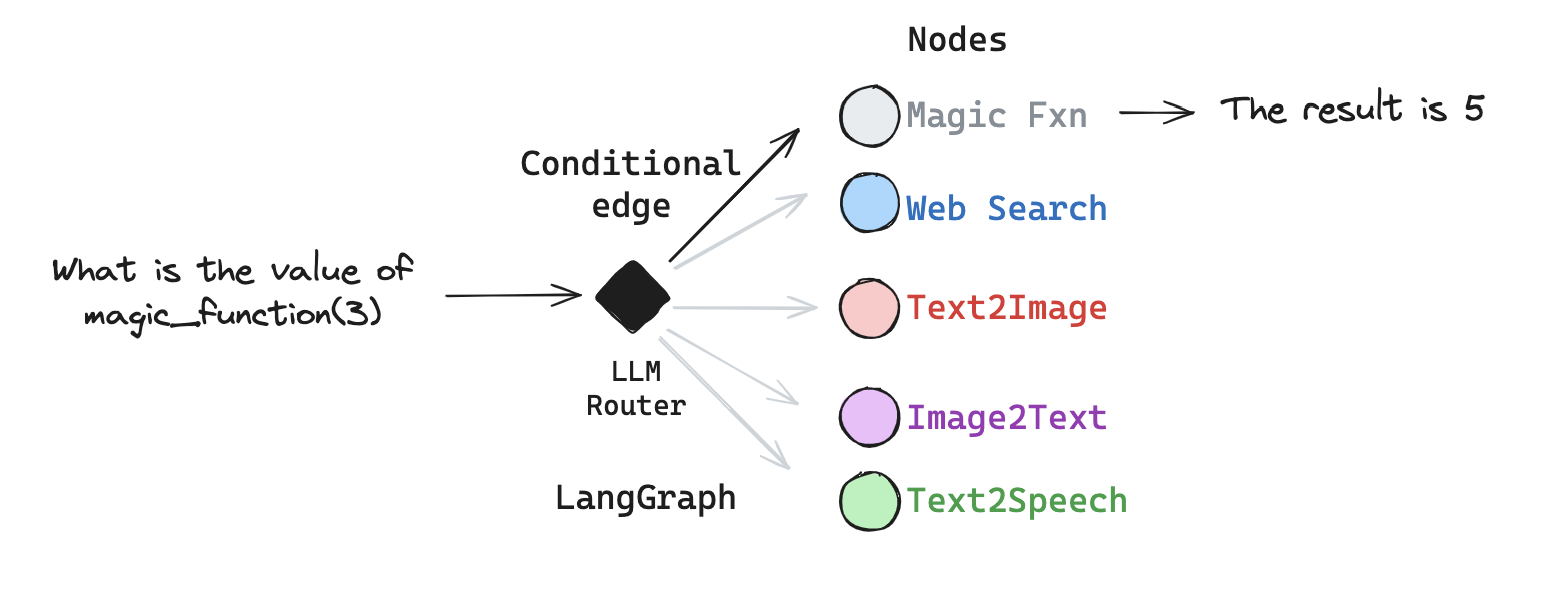

## Tools

### 1. Custom Function

We'll define a few tools that our agent will use.

In [41]:
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

magic_function(3)

5

### 2. Web Search

Let's use [Tavily](https://tavily.com/#api) for web search.

In [ ]:
# Ensure API key is set
import os
from getpass import getpass
TAVILY_API_KEY = getpass()
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [49]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

### 3. Text-2-Image

We'll use [Replicate](https://replicate.com/), which offers free to try API key and hosts an [open DALL-E model](https://replicate.com/lucataco/open-dalle-v1.1/versions/1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144).

Test the code before converting it to a tool (this may take 1-2 minutes to run):

In [2]:
# Ensure API key is set
REPLICATE_API_TOKEN = getpass()
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

['https://replicate.delivery/pbxt/OZifEKoZ2AwcViRZNX0HBk7weCeGg1E0TG6oixRXaD3bWZllA/out-0.png']


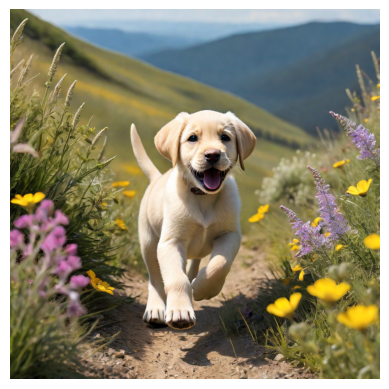

In [16]:
import replicate
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(image_url):
    """Display generated image"""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))  
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def text2image(text: str) -> str:
    """generate an image based on a text."""
    output = replicate.run(
        "lucataco/open-dalle-v1.1:1c7d4c8dec39c7306df7794b28419078cb9d18b9213ab1c21fdc46a1deca0144",
        input={
            "width": 1024,
            "height": 1024,
            "prompt": text, #"a yellow lab puppy running free with wild flowers in the mountain behind",
            "scheduler": "KarrasDPM",
            "num_outputs": 1,
            "guidance_scale": 7.5,
            "apply_watermark": True,
            "negative_prompt": "worst quality, low quality",
            "prompt_strength": 0.8,
            "num_inference_steps": 60
        }
    )
    print(output)
    return output[0]

output = text2image("a yellow lab puppy running free with wild flowers in the mountain behind")
display_image(output)

### 4. Image-2-Text

We'll use Replicate, which hosts [llava-13b](https://replicate.com/yorickvp/llava-13b).

Test the code before converting it to a tool:

In [59]:
def image2text(image_url: str, prompt: str) -> int:
    """generate a text on image_url based on prompt."""
    input = {
        "image": image_url,
        "prompt": prompt
    }

    output = replicate.run(
        "yorickvp/llava-13b:b5f6212d032508382d61ff00469ddda3e32fd8a0e75dc39d8a4191bb742157fb",
        input=input
    )

    return "".join(output)

text = image2text(image_url,"tell me a bedtime story about the image")
text

"Once upon a time, in a beautiful valley nestled between two mountains, there lived a happy dog named Max. Max was a playful and energetic puppy who loved to explore the outdoors. One day, Max decided to venture out on a trail that led through a field of flowers, with mountains in the background. As he ran through the field, the vibrant colors of the flowers and the fresh mountain air filled his senses, making him feel alive and free.\n\nAs Max continued his journey, he came across a small stream, and he couldn't resist the opportunity to splash and play in the water. He happily wagged his tail and barked with joy, feeling the cool water on his fur. After playing for a while, Max decided to continue his adventure, running up the trail with a smile on his face.\n\nAs the sun began to set, Max found a comfortable spot to rest, surrounded by the beautiful flowers and the soothing sounds of nature. He curled up and closed his eyes, feeling content and at peace, knowing that he had experien

### 5. Text-2-Speech

We'll use Replicate, which hosts [text-2-speech](https://replicate.com/cjwbw/seamless_communication).

In [26]:
from IPython.display import Audio

def play_audio(output_url):
    return Audio(url=output_url, autoplay=False)

def text2speech(text: str) -> int:
    """convert a text to a speech."""
    output = replicate.run(
        "cjwbw/seamless_communication:668a4fec05a887143e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
        input={
            "task_name": "T2ST (Text to Speech translation)",
            "input_text": text,
            "input_text_language": "English",
            "max_input_audio_length": 60,
            "target_language_text_only": "English",
            "target_language_with_speech": "English"
        }
    )
    return output['audio_output']

output_url = text2speech(text)
play_audio(output_url)

## Graph state 

The graph state will serve as short-term memory that persists during the lifetime of our agent. 

See [this overview](https://github.com/langchain-ai/langgraph) of LangGraph for more detail.

In [27]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        instructions: user input
        image_url: image url
        answer: agent answer
    """
    instructions : str
    image_url : str
    audio_url : str
    answer : str

## Graph nodes and edges

### Conditional edge

Edges connect nodes.

Our agent will start with user instructions.

We will use a router to choose which node to visit first.

The process of choosing one of many tool nodes is a `conditional edge`.

For routing, can review LangChain LLM integrations that structured outputs [here](https://python.langchain.com/docs/integrations/chat/). Groq is included.

In [ ]:
# Ensure API key is set
GROQ_API_KEY = getpass()
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [19]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    tool: Literal["magic_fxn", "web_search", "text2speech", "image2text", "text2image"] = Field(
        ...,
        description="Given a user question choose to route it to the relevant tool.",
    )

# LLM with function call 
llm = ChatGroq(temperature=0, model="llama3-70b-8192")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to one of five tools:
(1) magic_fxn: route any questions that ask for magic_function(x) to magic_fxn
(2) text2speech: route any questions that ask to convert the text to speech to text2speech
(3) image2text: route any questions that ask to convert this image into ... to image2text
(4) text2image: route any questions that ask to generate an image to text2image
(5) web_search: route any remaining questions web_search"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{instructions}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"instructions": "convert this image url to a bedtime story"}))
print(question_router.invoke({"instructions": "generate an image based on this text"}))
print(question_router.invoke({"instructions": "whats the weather in SF"}))
print(question_router.invoke({"instructions": "what is the value of magic_function"}))
print(question_router.invoke({"instructions": "convert the text to speech"}))

tool='image2text'
tool='text2image'
tool='web_search'
tool='magic_fxn'
tool='text2speech'


Then, wrap it as a function within our graph, which takes state as an input.

In [36]:
def route_question(state):
    """
    Route instructions to tool.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    instructions = state["instructions"]
    source = question_router.invoke({"instructions": instructions})  
    return source.tool

### Nodes

In [64]:
from langchain import hub
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

def call_magic_function(state):
    """
    Call magic function

    Args:
        state (dict): The current graph state

    Returns:
        str: New key added to state, answer, that contains magic_function
    """

    print("---MAGIC FUNCTION QUESTION---")
    instructions = state["instructions"]

    # Data model
    class MagicFxnArg(BaseModel):
        """Extract the argument for magic function."""
    
        arg: int = Field(...,
            description="The input argument for magic function.",
        )
    
    # LLM with function call 
    llm = ChatGroq(temperature=0, model="llama3-70b-8192")
    structured_llm = llm.with_structured_output(MagicFxnArg)
    
    # Prompt 
    system = """You will extract the argument to a function, magic_function(x) from
    user input. In this case, the argument you will extract is 'x'. Return 'x' with
    no preamble or explaination (it will be used to invoke the function)."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{instructions}"),
        ]
    )

    # Invoke
    magic_function_parser = prompt | structured_llm
    magic_function_input = magic_function_parser.invoke({"instructions":instructions})
    result = magic_function(magic_function_input.arg)
    return {"instructions": instructions, "answer": f"The output of magic_function({magic_function_input.arg}) is {result}"}

def call_web_search(state):
    """
    Call web search

    Args:
        state (dict): The current graph state

    Returns:
        str: New key added to state, answer, that contains web search results
    """

    print("---WEB SEARCH---")
    instructions = state["instructions"]
    docs = web_search_tool.invoke({"query": instructions})
    web_search = "\n".join([d["content"] for d in docs])
    
    # Prompt
    prompt = hub.pull("rlm/rag-prompt-llama3")
    
    # LLM
    llm = ChatGroq(temperature=0, model="llama3-70b-8192")
    
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": web_search, "question": instructions})
    return {"instructions": instructions, "answer": generation}

def call_text_2_image(state):
    """
    Call text to image

    Args:
        state (dict): The current graph state

    Returns:
        str: New key added to state, image_url, that contains image_url
    """

    print("---Text 2 Image---")
    instructions = state["instructions"]
    output = text2image(instructions)
    return {"instructions": instructions, "image_url": output}

def call_image_2_text(state):
    """
    Call image to text

    Args:
        state (dict): The current graph state

    Returns:
        str: New key added to 
    """

    print("---Image 2 Text---")
    instructions = state["instructions"]
    image_url = state["image_url"]
    output = image2text(image_url,instructions)
    return {"instructions": instructions, "answer": output}

def call_text_2_speech(state):
    """
    Call text to speech

    Args:
        state (dict): The current graph state

    Returns:
        str: New key added to state, audio_url, that contains audio_url
    """

    print("---Text 2 Speech---")
    instructions = state["instructions"]
    output = text2speech(instructions)
    return {"instructions": instructions, "audio_url": output}

### Graph

Here, we lay out the graph.

In [65]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("magic_fxn", call_magic_function) 
workflow.add_node("web_search", call_web_search) 
workflow.add_node("text2image", call_text_2_image) 
workflow.add_node("image2text", call_image_2_text) 
workflow.add_node("text2speech", call_text_2_speech) 

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {   # Decision from edge -> Next node to visit
        "magic_fxn": "magic_fxn",
        "web_search": "web_search",
        "text2image": "text2image",
        "image2text": "image2text",
        "text2speech": "text2speech",
    },
)
workflow.add_edge("magic_fxn", END)
workflow.add_edge("web_search", END)
workflow.add_edge("text2image", END)
workflow.add_edge("image2text", END)
workflow.add_edge("text2speech", END)

# Compile
app = workflow.compile()

In [47]:
app.invoke({"instructions":"what is the value of magic_function(3)?"})

---ROUTE QUESTION---
---MAGIC FUNCTION QUESTION---


{'instructions': 'what is the value of magic_function(3)?',
 'answer': 'The output of magic_function(3) is 5'}

Trace: 

https://smith.langchain.com/public/911a543e-509b-485b-aadc-a375d540bad6/r

In [58]:
app.invoke({"instructions":"what is the weather in SF?"})

---ROUTE QUESTION---
---WEB SEARCH---


{'instructions': 'what is the weather in SF?',
 'answer': 'The weather in San Francisco is partly cloudy with a temperature of 75.9°F (24.4°C) and feels like 76.6°F (24.8°C).'}

Trace: 

https://smith.langchain.com/public/f2dbee68-ccc8-4283-9297-40b57070b696/r

In [59]:
output = app.invoke({"instructions":"generate an image based upon this text: 'a yellow lab puppy running free with wild flowers in the mountain behind'"})

---ROUTE QUESTION---
---Text 2 Image---
['https://replicate.delivery/pbxt/tqUA010JF3a9DVD8p0XBTZcWcTHs96TCzP6gsZxDW6l1yrsE/out-0.png']


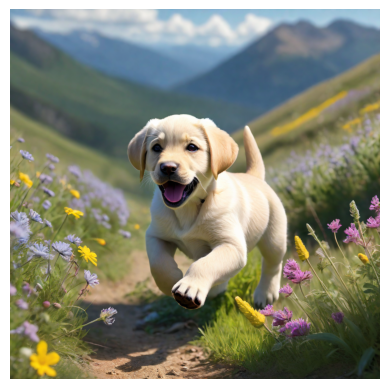

In [60]:
display_image(output['image_url'])

Trace: 

https://smith.langchain.com/public/5657c35c-c57c-4d1e-8c47-04d1e94edb25/r

In [67]:
output_i2t = app.invoke({"instructions":"tell me a story about this image", "image_url":output['image_url']})

---ROUTE QUESTION---
---Image 2 Text---


In [69]:
output_i2t['answer']

"In the image, a small white puppy is happily running through a field filled with colorful flowers. The puppy appears to be enjoying the outdoors and the vibrant surroundings. The field is lush and green, with a variety of flowers scattered throughout the area. The puppy's playful demeanor and the lively atmosphere of the field create a sense of joy and freedom, as the puppy explores its environment and takes in the beauty of the flowers."

Trace: 

https://smith.langchain.com/public/0d1cac25-558e-4b36-805a-1cd619bb7b87/r

In [70]:
output = app.invoke({"instructions":f"convert this text to speech: {output_i2t['answer']}"})

---ROUTE QUESTION---
---Text 2 Speech---


In [73]:
play_audio(output['audio_url'])

Trace: 

https://smith.langchain.com/public/d0e8ff27-4eb1-46ac-a8f0-84f3a53fd71f/r

Agent Executor is a nice and useful higher-level abstraction, with less code and more abstraction, but harder to audit and less reliable.
LangGraph is lower level, with more code (all the details of each tool use are specified in each node), less abstraction, easier to audit, and more reliable. LangGraph is more effort to implement, but we understand exactly what is going on. In the next [notebook](langgraph-rag-agent), we'll show how to apply LangGraph to build advanced Llama 3 powered RAG agents.